In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.preprocessing import MinMaxScaler


In [4]:
sys.path.append(os.path.abspath('../scripts'))
from utility import read_csv_file, detect_outliers_iqr, get_top_bottom_frequent

Read Preprocessed dataset

In [5]:
data_path = '../data/preprocessed.csv'
telecom_data = read_csv_file(data_path)

In [6]:
telecom_data = telecom_data.get("data")
telecom_data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,104608.43895,208201448079117,33664962239,35521209507511,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,104608.43895,208201909211140,33681854413,35794009006359,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,104608.43895,208200314458056,33760627129,35281510359387,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,104608.43895,208201402342131,33750343200,35356610164913,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,104608.43895,208201401415120,33699795932,35407009745539,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


Aggregate the required features

In [7]:
# Aggregate per customer
aggregated_data = telecom_data.groupby("MSISDN/Number").agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode()[0] if not x.mode().empty else np.nan
}).reset_index()

aggregated_data.rename(columns={
    'TCP DL Retrans. Vol (Bytes)': 'Avg TCP Retransmission',
    'Avg RTT DL (ms)': 'Avg RTT',
    'Avg Bearer TP DL (kbps)': 'Avg Throughput'
}, inplace=True)

aggregated_data.head()


,MSISDN/Number,Avg TCP Retransmission,TCP UL Retrans. Vol (Bytes),Avg RTT,Avg RTT UL (ms),Avg Throughput,Avg Bearer TP UL (kbps),Handset Type
0,33601001722,568730.000000,20949.500000,46.0,0.0,37.000000,39.000000,Huawei P20 Lite Huawei Nova 3E
1,33601001754,568730.000000,20949.500000,30.0,1.0,48.000000,51.000000,Apple iPhone 7 (A1778)
2,33601002511,568730.000000,20949.500000,45.0,5.0,48.000000,49.000000,undefined
3,33601007832,1066.000000,20949.500000,69.0,15.0,204.000000,44.000000,Apple iPhone 5S (A1457)
4,33601008617,546303.138255,20145.219517,57.0,2.5,3983.390677,905.208632,Apple iPhone Se (A1723)


Compute and List Top, Bottom, and Most Frequent

In [8]:
tcp_top, tcp_bottom, tcp_frequent = get_top_bottom_frequent(telecom_data,'TCP DL Retrans. Vol (Bytes)')
rtt_top, rtt_bottom, rtt_frequent = get_top_bottom_frequent(telecom_data, 'Avg RTT DL (ms)')
throughput_top, throughput_bottom, throughput_frequent = get_top_bottom_frequent(telecom_data,'Avg Bearer TP DL (kbps)')

print("Top 10 TCP:", tcp_top)
print("Bottom 10 TCP:", tcp_bottom)
print("Most Frequent TCP:", tcp_frequent)


Top 10 TCP: [568730. 568730. 568730. 568730. 568730. 568730. 568730. 568730. 568730.
 568730.]
Bottom 10 TCP: [2. 2. 4. 4. 4. 4. 4. 4. 4. 4.]
Most Frequent TCP: [568730.0, 523876.27650954056, 1330.0, 2660.0, 38.0, 92.0, 1318.0, 543.0, 3990.0, 76.0]


Distribution Analysis

In [9]:
telecom_data['Avg Bearer TP DL (kbps)'].describe()

count    150001.000000
mean       3663.163190
std        5232.918274
min           0.000000
25%          43.000000
50%          63.000000
75%        7266.000000
max       19794.000000
Name: Avg Bearer TP DL (kbps), dtype: float64

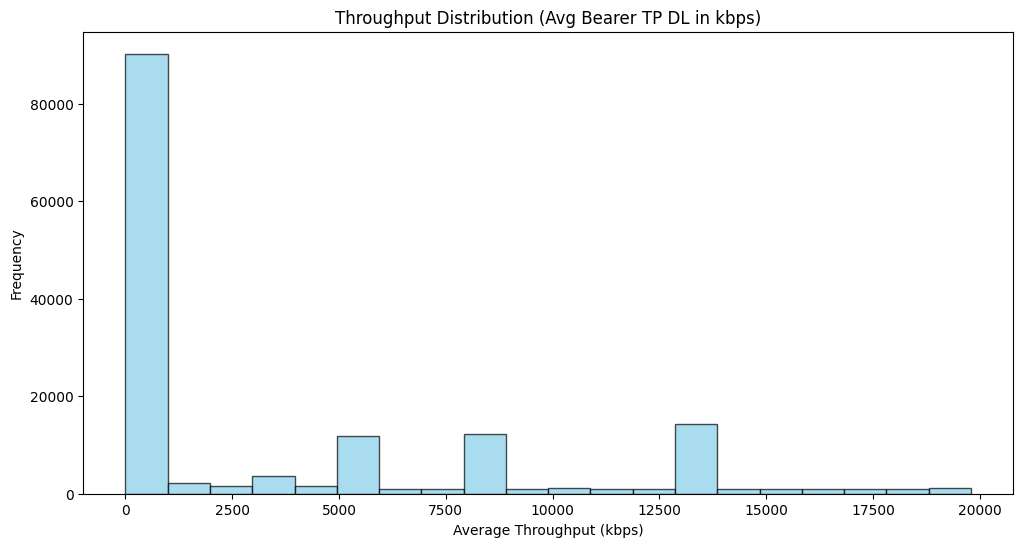

In [11]:
# Histogram for Throughput Distribution
plt.figure(figsize=(12, 6))
throughput_values = telecom_data['Avg Bearer TP DL (kbps)'].dropna()
plt.hist(throughput_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Throughput Distribution (Avg Bearer TP DL in kbps)')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Frequency')
plt.show()



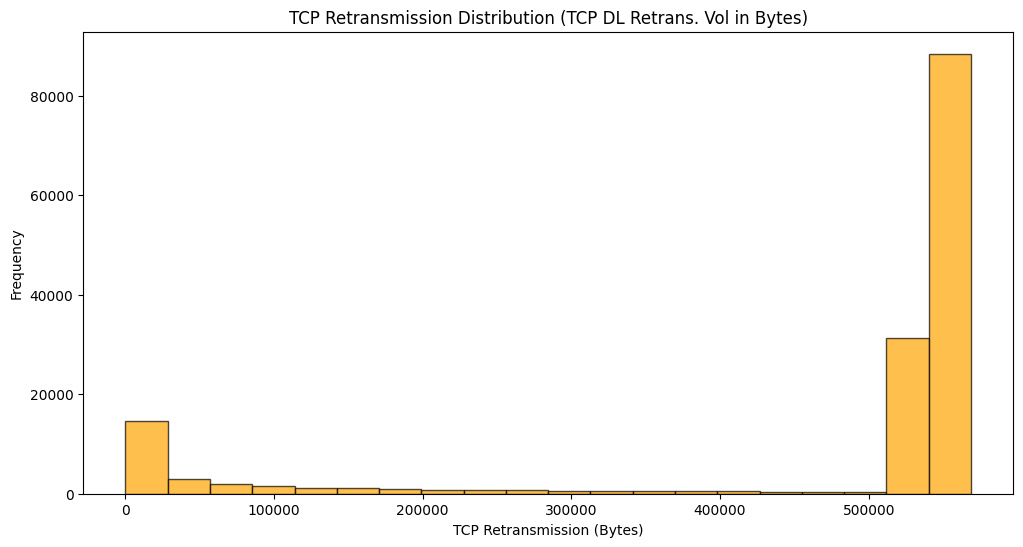

In [13]:
# Histogram for TCP Retransmission Distribution
plt.figure(figsize=(12, 6))
tcp_retrans_values = telecom_data['TCP DL Retrans. Vol (Bytes)'].dropna()
plt.hist(tcp_retrans_values, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.title('TCP Retransmission Distribution (TCP DL Retrans. Vol in Bytes)')
plt.xlabel('TCP Retransmission (Bytes)')
plt.ylabel('Frequency')
plt.show()


In [14]:
telecom_data['TCP DL Retrans. Vol (Bytes)'].describe()

count    150001.000000
mean     464975.497914
std      193391.516827
min           2.000000
25%      523876.276510
50%      568730.000000
75%      568730.000000
max      568730.000000
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

In [8]:
# Define the columns to check for outliers
skewed_columns = [
    'Avg TCP Retransmission',
    'TCP UL Retrans. Vol (Bytes)',
    'Avg RTT',
    'Avg RTT UL (ms)',
    'Avg Throughput',
    'Avg Bearer TP UL (kbps)'
]

# Call the function to detect outliers
outliers_detected = detect_outliers_iqr(aggregated_data, skewed_columns, id_col="MSISDN/Number")

# # Display the detected outliers
# print("Outliers detected:")
# for col, ids in outliers_detected.items():
#     print(f"{col}: {len(ids)} outliers found")
#     print("Preview of IDs:", ids[:10])  # Display the first 10 IDs as a preview


Column: Avg TCP Retransmission - Number of outliers: 0
Lower bound: 0 & Upper bound: 646240.1722316918

Column: TCP UL Retrans. Vol (Bytes) - Number of outliers: 0
Lower bound: 0 & Upper bound: 23362.34144831822

Column: Avg RTT - Number of outliers: 154
Lower bound: 0 & Upper bound: 100.0

Column: Avg RTT UL (ms) - Number of outliers: 3252
Lower bound: 0 & Upper bound: 18.0

Column: Avg Throughput - Number of outliers: 3132
Lower bound: 0 & Upper bound: 14043.0

Column: Avg Bearer TP UL (kbps) - Number of outliers: 1495
Lower bound: 0 & Upper bound: 2191.021579856135



In [9]:
# Replace outliers with the mean of non-outliers
for col in skewed_columns:
    # Calculate the IQR
    Q1 = aggregated_data[col].quantile(0.25)
    Q3 = aggregated_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)  # Set lower bound to 0 if negative
    upper_bound = Q3 + 1.5 * IQR
    
    # Calculate the mean of non-outlier values
    non_outlier_mean = aggregated_data[(aggregated_data[col] >= lower_bound) & 
                                       (aggregated_data[col] <= upper_bound)][col].mean()
    
    # Replace outliers with the mean
    aggregated_data[col] = aggregated_data[col].apply(
        lambda x: non_outlier_mean if x < lower_bound or x > upper_bound else x
    )

# Display the updated dataset
print("Outliers have been replaced with the mean.")
aggregated_data.head()


Outliers have been replaced with the mean.


,MSISDN/Number,Avg TCP Retransmission,TCP UL Retrans. Vol (Bytes),Avg RTT,Avg RTT UL (ms),Avg Throughput,Avg Bearer TP UL (kbps),Handset Type
0,33601001722,568730.000000,20949.500000,46.0,0.0,37.000000,39.000000,Huawei P20 Lite Huawei Nova 3E
1,33601001754,568730.000000,20949.500000,30.0,1.0,48.000000,51.000000,Apple iPhone 7 (A1778)
2,33601002511,568730.000000,20949.500000,45.0,5.0,48.000000,49.000000,undefined
3,33601007832,556349.270971,20949.500000,69.0,15.0,204.000000,44.000000,Apple iPhone 5S (A1457)
4,33601008617,546303.138255,20145.219517,57.0,2.5,3983.390677,905.208632,Apple iPhone Se (A1723)


In [10]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106856 entries, 0 to 106855
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   MSISDN/Number                106856 non-null  int64  
 1   Avg TCP Retransmission       106856 non-null  float64
 2   TCP UL Retrans. Vol (Bytes)  106856 non-null  float64
 3   Avg RTT                      106856 non-null  float64
 4   Avg RTT UL (ms)              106856 non-null  float64
 5   Avg Throughput               106856 non-null  float64
 6   Avg Bearer TP UL (kbps)      106856 non-null  float64
 7   Handset Type                 106856 non-null  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 6.5+ MB


K-Means Clustering

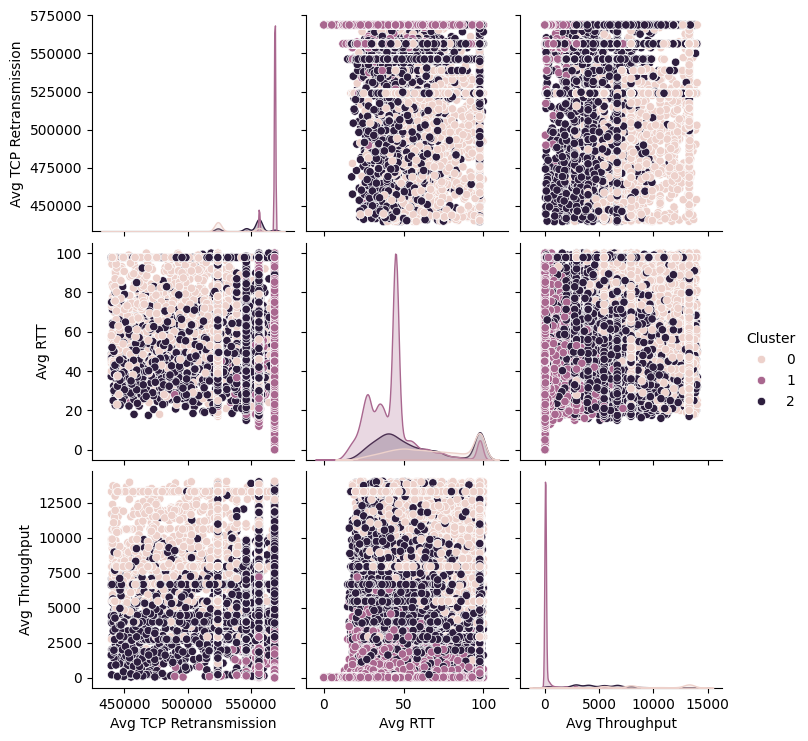

Cluster Centers (mean values of each cluster):
   Avg TCP Retransmission  TCP UL Retrans. Vol (Bytes)   Avg RTT  \
0                0.704343                     0.701178  0.695228   
1                0.989642                     0.993032  0.424557   
2                0.839940                     0.841546  0.568638   

   Avg RTT UL (ms)  Avg Throughput  Avg Bearer TP UL (kbps)  
0         0.674579        0.653633                 0.708073  
1         0.236207        0.015510                 0.033877  
2         0.393525        0.358556                 0.324168  

Cluster Summary:
         MSISDN/Number  Avg TCP Retransmission  TCP UL Retrans. Vol (Bytes)  \
Cluster                                                                       
0         3.367892e+10           530570.912264                 19748.810773   
1         5.330256e+10           567396.050568                 20921.639510   
2         3.367304e+10           548078.107006                 20312.444219   

           Avg RTT

In [11]:
# Select numerical features for clustering
clustering_data = aggregated_data[['Avg TCP Retransmission', 'TCP UL Retrans. Vol (Bytes)', 
                                   'Avg RTT', 'Avg RTT UL (ms)', 'Avg Throughput', 'Avg Bearer TP UL (kbps)']]

# Apply Min-Max scaling (scaling values between 0 and 1)
scaler = MinMaxScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Perform K-Means clustering (let's choose 3 clusters for now)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Add the cluster labels to the original dataset
aggregated_data['Cluster'] = clusters

# Visualize the clusters using a pairplot
sns.pairplot(aggregated_data, hue='Cluster', vars=['Avg TCP Retransmission', 'Avg RTT', 'Avg Throughput'])
plt.show()

# Print the cluster centers (mean values of each cluster)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=clustering_data.columns)
print("Cluster Centers (mean values of each cluster):")
print(cluster_centers)

# Summary of each cluster: Filter only numeric columns
numeric_cols = aggregated_data.select_dtypes(include=['number']).columns
cluster_means = aggregated_data[numeric_cols].groupby(aggregated_data['Cluster']).mean()

# Print the cluster summary
print("\nCluster Summary:")
print(cluster_means)
